<a href="https://colab.research.google.com/github/VadPA/PyTorch/blob/master/Lesson_4_hw_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import pickle
import os

In [66]:
import matplotlib.pyplot as plt
from torchsummary import summary

In [67]:
def load_labels_name(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [68]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [69]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [70]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

Files already downloaded and verified


In [71]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

In [72]:
train_dataset, valid_dataset = train_valid_split(dataset)

In [73]:
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [74]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [75]:
files = os.listdir('data/cifar-100-python')
print(files)

['meta', 'file.txt~', 'train', 'test']


In [76]:
data_cifar100 = load_labels_name('data/cifar-100-python/meta')

In [77]:
classes_cifar100 = data_cifar100['fine_label_names']

torch.Size([128, 3, 32, 32])
chair


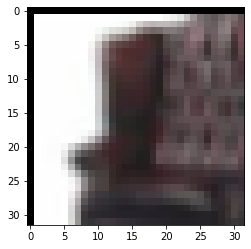

In [78]:
for img, lbl in train_loader:
    print(img.shape)
    print(classes_cifar100[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [79]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [86]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 60, 3)
        self.bn_two = torch.nn.BatchNorm2d(60) 
        self.conv_two = torch.nn.Conv2d(60, 90, 3)
        self.bn_three = torch.nn.BatchNorm2d(90)
        self.conv_three = torch.nn.Conv2d(90, 150, 3)
        self.bn_four = torch.nn.BatchNorm2d(150)
        self.fc1 = torch.nn.Linear(600, 300)
        self.fc2 = torch.nn.Linear(300, 160)
        self.out = torch.nn.Linear(160, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

In [87]:
net = Net()
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(60, 90, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(90, 150, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=160, bias=True)
  (out): Linear(in_features=160, out_features=100, bias=True)
)


In [88]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [89]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 60, 30, 30]           1,680
       BatchNorm2d-3           [-1, 60, 15, 15]             120
            Conv2d-4           [-1, 90, 13, 13]          48,690
       BatchNorm2d-5             [-1, 90, 6, 6]             180
            Conv2d-6            [-1, 150, 4, 4]         121,650
       BatchNorm2d-7            [-1, 150, 2, 2]             300
           Dropout-8                  [-1, 600]               0
            Linear-9                  [-1, 300]         180,300
          Dropout-10                  [-1, 300]               0
           Linear-11                  [-1, 160]          48,160
           Linear-12                  [-1, 100]          16,100
Total params: 417,186
Trainable params: 417,186
Non-trainable params: 0
-------------------------------

In [90]:
num_epochs = 25
net.train()

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(60, 90, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(90, 150, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=160, bias=True)
  (out): Linear(in_features=160, out_features=100, bias=True)
)

In [91]:
for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels  == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader, 0):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/25]. Step [1/372]. Loss: 0.036. Acc: 0.008. Test acc: 0.010
Epoch [1/25]. Step [301/372]. Loss: 0.031. Acc: 0.086. Test acc: 0.098
Epoch [2/25]. Step [1/372]. Loss: 0.029. Acc: 0.133. Test acc: 0.103
Epoch [2/25]. Step [301/372]. Loss: 0.028. Acc: 0.151. Test acc: 0.163
Epoch [3/25]. Step [1/372]. Loss: 0.024. Acc: 0.242. Test acc: 0.138
Epoch [3/25]. Step [301/372]. Loss: 0.026. Acc: 0.195. Test acc: 0.164
Epoch [4/25]. Step [1/372]. Loss: 0.024. Acc: 0.227. Test acc: 0.176
Epoch [4/25]. Step [301/372]. Loss: 0.025. Acc: 0.221. Test acc: 0.199
Epoch [5/25]. Step [1/372]. Loss: 0.023. Acc: 0.250. Test acc: 0.200
Epoch [5/25]. Step [301/372]. Loss: 0.024. Acc: 0.238. Test acc: 0.202
Epoch [6/25]. Step [1/372]. Loss: 0.023. Acc: 0.250. Test acc: 0.204
Epoch [6/25]. Step [301/372]. Loss: 0.023. Acc: 0.257. Test acc: 0.213
Epoch [7/25]. Step [1/372]. Loss: 0.024. Acc: 0.297. Test acc: 0.207
Epoch [7/25]. Step [301/372]. Loss: 0.023. Acc: 0.267. Test acc: 0.220
Epoch [8/25]. Step [

In [92]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=1)

In [93]:
data_iter = iter(valid_loader)
inputs, labels = data_iter.next()
labels = labels.to(device)
inputs = inputs.to(device)
labels

tensor([30,  7, 89, 25, 27, 85, 59,  0], device='cuda:0')

In [94]:
import torchvision

GroundTruth:  dolphin beetle tractor couch crocodile tank pine_tree apple


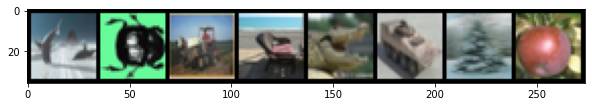

In [95]:
net.eval()
outputs = net(inputs)
imgs = torchvision.utils.make_grid(inputs.to('cpu'))
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes_cifar100[labels[j]] for j in range(len(labels))))

In [96]:
print(outputs)

tensor([[-1.2428e+01, -2.4094e-01, -3.7597e+00, -2.8749e+00, -1.1922e+00,
         -2.3801e+00, -4.2525e+00, -1.5207e+00,  1.0797e-01, -4.1777e+00,
         -9.8514e-01, -4.6867e+00,  5.6588e-01,  1.2835e+00, -3.6105e+00,
         -2.5714e+00, -2.5353e+00, -3.6729e+00, -1.5857e+00, -2.2415e+00,
         -2.5536e+00, -4.0128e+00, -1.1853e+00, -2.7585e+00, -2.7508e+00,
         -1.0682e+00,  9.6408e-01, -1.5019e+00, -2.8618e+00, -9.0518e-01,
          1.8316e-01, -4.1648e+00, -1.9421e+00, -2.6172e+00, -1.1110e+00,
         -4.8964e+00, -4.9117e+00,  4.2153e-01, -2.0206e+00, -2.0495e+00,
         -1.3482e+00, -3.6636e+00, -2.8328e+00, -7.8349e+00, -4.7334e-01,
          5.5464e-01, -4.3860e+00, -6.6971e+00,  6.0355e-01,  1.1884e+00,
         -8.5067e-01, -5.3615e+00, -4.2040e+00, -1.0469e+01, -4.1718e+00,
         -3.1615e-01, -2.8234e+00, -7.3951e+00,  1.9887e+00, -3.9358e+00,
         -4.2206e+00, -3.0249e+00, -7.0870e+00, -3.7433e+00, -2.1352e+00,
         -1.0521e+00, -6.8457e-02, -3.

In [97]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([58, 14,  8, 95, 27, 93, 59,  0], device='cuda:0')

In [98]:
print('Predicted: ', ' '.join(classes_cifar100[predicted[j]] for j in range(len(labels))))

Predicted:  pickup_truck butterfly bicycle whale crocodile turtle pine_tree apple


In [99]:
gt = np.array([classes_cifar100[labels[j]] for j in range(len(labels))])
pred = np.array([classes_cifar100[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt):.4f}')

['dolphin' 'beetle' 'tractor' 'couch' 'crocodile' 'tank' 'pine_tree'
 'apple']
['pickup_truck' 'butterfly' 'bicycle' 'whale' 'crocodile' 'turtle'
 'pine_tree' 'apple']
Accuracy is 0.3750
